In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
import tensorflow as tf
# Eager Execution to display tensor values in NOtebook itself 
# tf.enable_eager_execution()
tf.__version__

'2.0.0'

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
# Load Image Paths
path = "F:/Fractal Generation/Anime_Faces_Dataset_Processed/"
images = os.listdir( path )
images_path = []

for image in images:
    images_path.append(path+image)

In [5]:
len(images_path)

21551

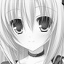

In [6]:
# See a Sample Image
import IPython.display as display
import random
image_path = random.choice(images_path)
display.display(display.Image(image_path))

In [7]:
path_ds = tf.data.Dataset.from_tensor_slices(images_path)

In [8]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [28, 28])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [9]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [10]:
image_ds

<DatasetV1Adapter shapes: (28, 28, 1), types: tf.float32>

In [11]:
BUFFER_SIZE =len(images_path)
BATCH_SIZE = 256
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE,drop_remainder=True)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (256, 28, 28, 1), types: tf.float32>

In [12]:
b_count = 1
for batch in ds:
    b_count = b_count + 1
    print(batch.shape)
print(b_count)

(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
generator = make_generator_model()
discriminator = make_discriminator_model()

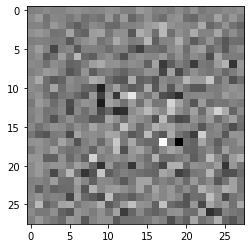

In [16]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

img = generated_image.numpy()
img = img[0].reshape(img.shape[1],img.shape[2])
plt.imshow(img, cmap='gray')

In [17]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00039352]], shape=(1, 1), dtype=float32)


In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    print(gen_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        b_count = 1
        for image_batch in dataset:
            #print('BATCH: {} EPOCH : {} '.format(str(b_count),epoch))
            b_count  = b_count + 1
            train_step(image_batch,epoch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = predictions.numpy()
        img = img[i].reshape(28,28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

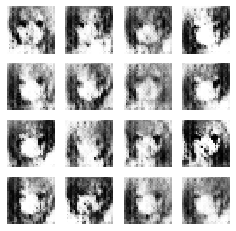

Wall time: 19min 10s


In [39]:
%%time
train(ds, EPOCHS)

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [41]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [52]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**2)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [53]:
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [55]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [57]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             